In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import numpy as np
import pandas as pd 
import os, json, pickle


In [3]:
import sys 
sys.path.append('../src')

from spaceoracle.oracles import SpaceOracle
from spaceoracle.tools.network import DayThreeRegulatoryNetwork, MouseKidneyRegulatoryNetwork

%config InlineBackend.figure_format = 'retina'

co_grn = DayThreeRegulatoryNetwork()
adata = sc.read_h5ad('.cache/adata_train.h5ad')

2024-11-08 13:18:17.290472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load model results

In [4]:
so = SpaceOracle(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models',
    annot='rctd_cluster', 
    grn=co_grn
)

In [5]:
goi = 'Il2'
goi in adata.var_names

True

In [6]:
# _ = so.perturb(target=goi, n_propagation=3, gene_expr=0, n_jobs=1)

# with open('.cache/lymph/beta_dict.pkl', 'wb') as f:
#     pickle.dump(so.beta_dict, f)

# np.save(f'.cache/lymph/{goi}_gem_simulated.npy', 
#         so.adata.layers['simulated_count'])

In [7]:
# gem_simulated = np.load(f'.cache/lymph/{goi}_0.03_gem_simulated.npy')
gem_simulated = np.load(f'.cache/lymph/{goi}_gem_simulated.npy')

so.adata.layers['simulated_count'] = gem_simulated

In [8]:
from sklearn.preprocessing import MinMaxScaler

gene_mtx = so.adata.layers['imputed_count']
gene_mtx = MinMaxScaler().fit_transform(gene_mtx)

delta_X = gem_simulated - gene_mtx
so.adata.layers['delta_X'] = delta_X

### View data

In [9]:
from spaceoracle.plotting.layout import *

# view_spatial2D(adata, annot='rctd_celltypes')view_spatial3D(adata, annot='rctd_celltypes', show=True, flat=False)

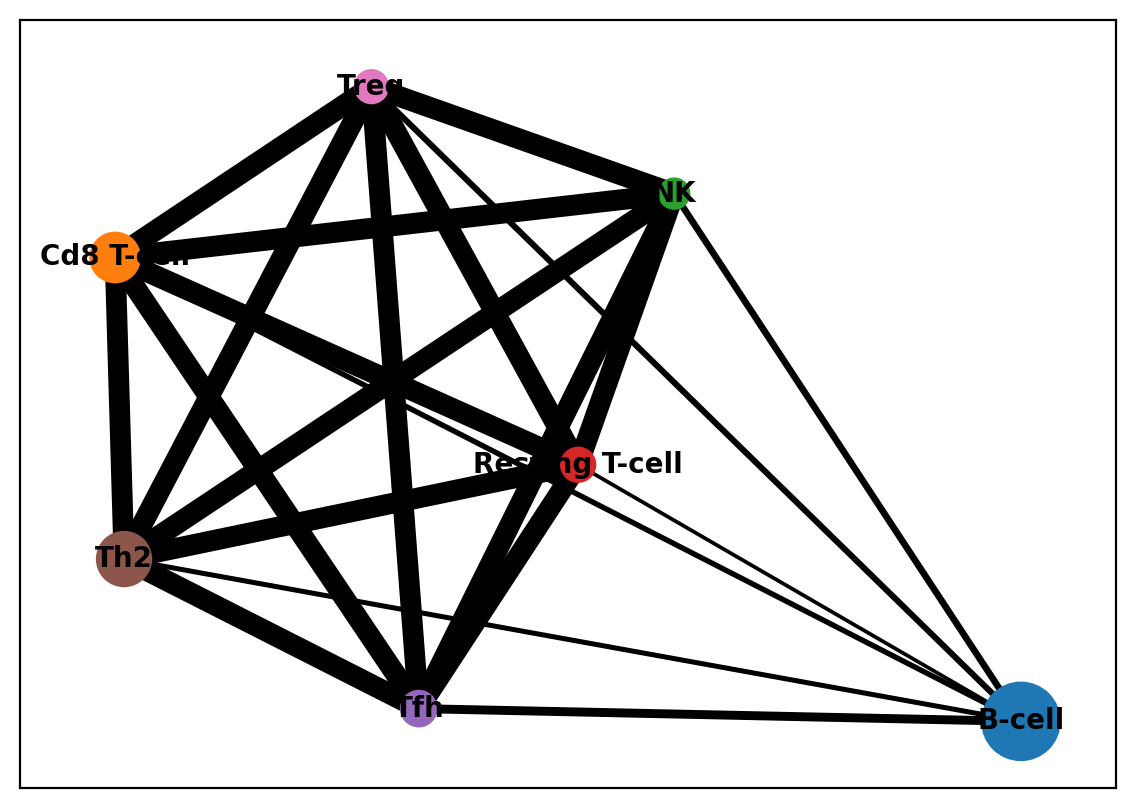

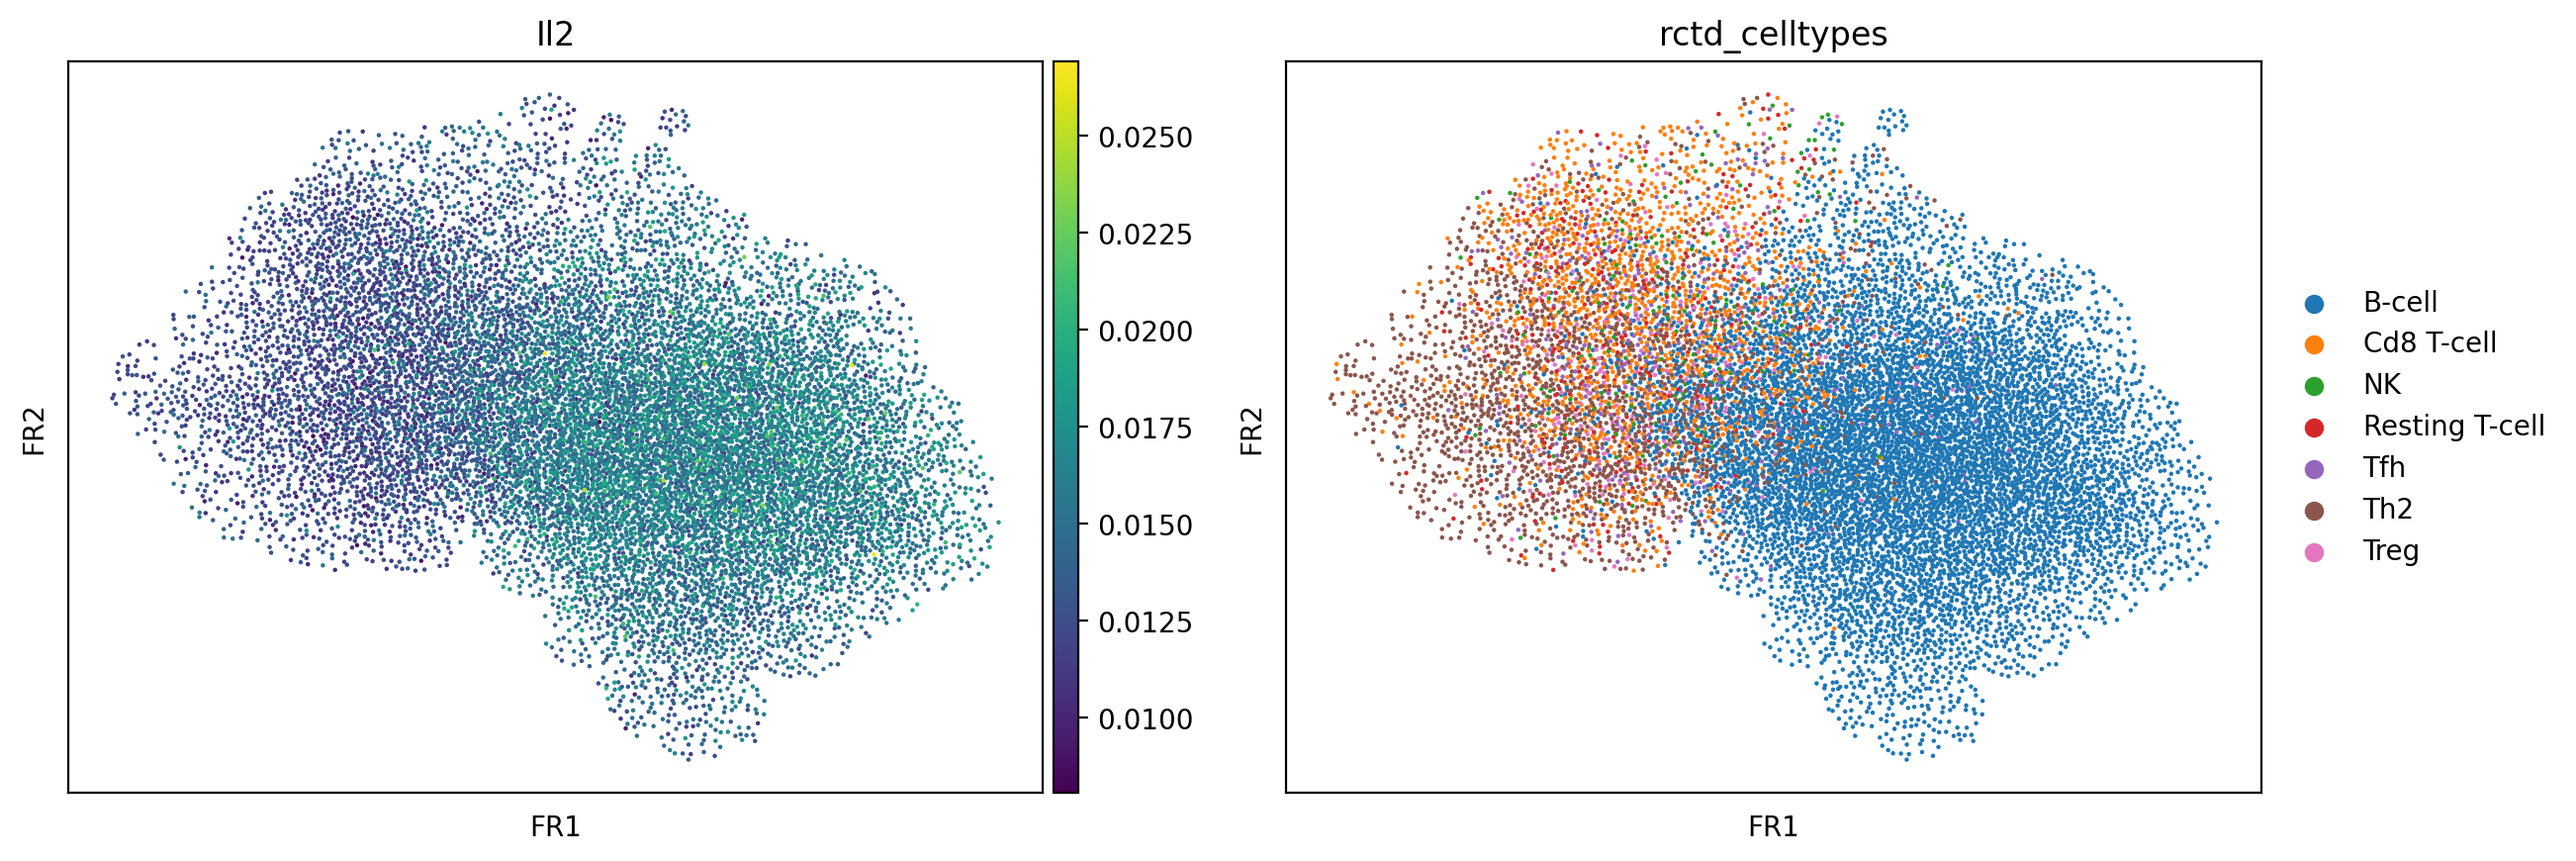

In [10]:
# compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='PCA')
# compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='UMAP')
compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='FR')

array([[<AxesSubplot: title={'center': 'Il2'}>]], dtype=object)

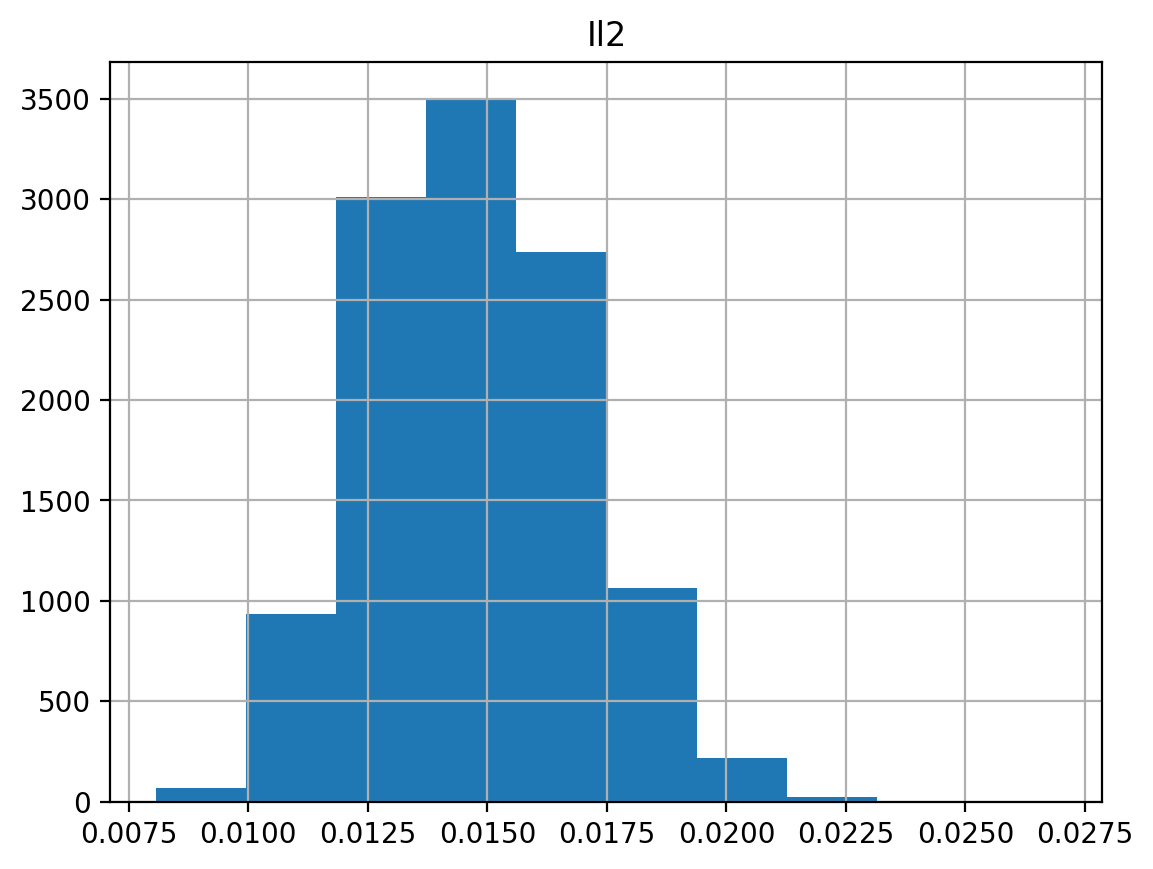

In [11]:
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()

In [12]:
so.pcs = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)

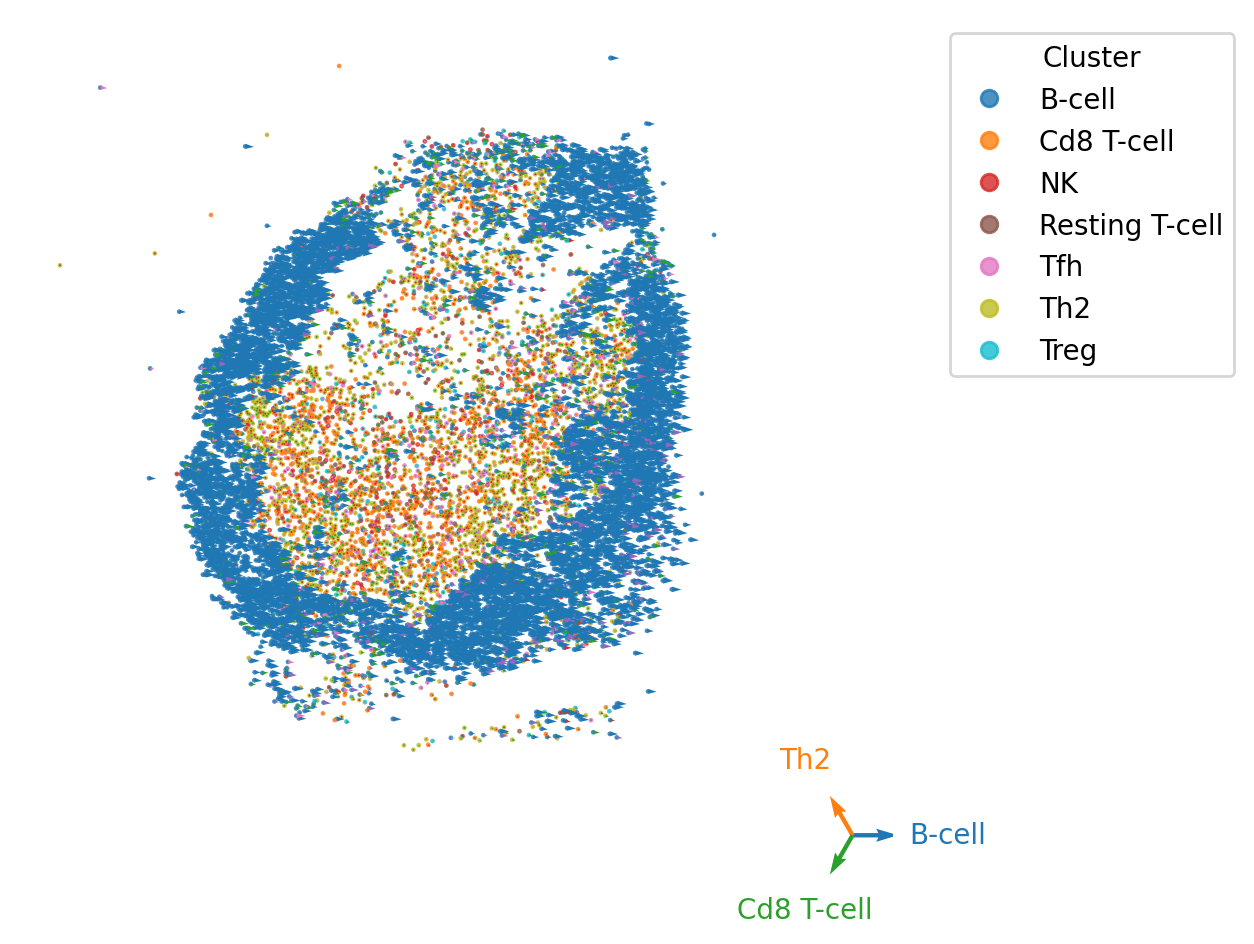

In [ ]:
# from spaceoracle.plotting.transitions import *
# from spaceoracle.plotting.randomize import *

# estimate_transitions_2D(
#     so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
#     annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)

# randomize_transitions_2D(
#     so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
#     annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)


from spaceoracle.plotting.shift import *

estimate_transitions(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_celltypes', n_neighbors=200, vector_scale=10,
    visual_clusters=['B-cell', 'Th2', 'Cd8 T-cell'], 
    renormalize=False, n_jobs=1)

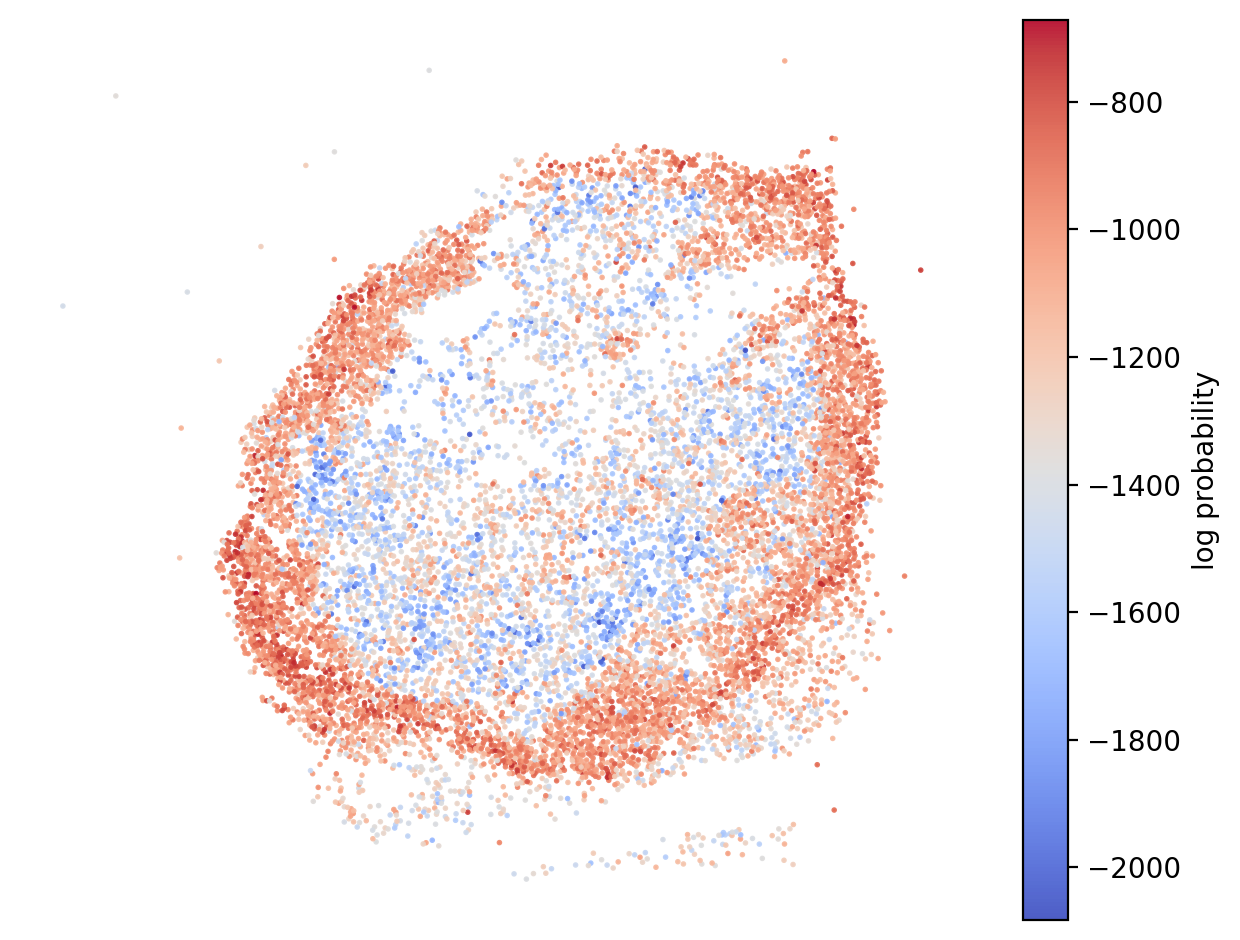

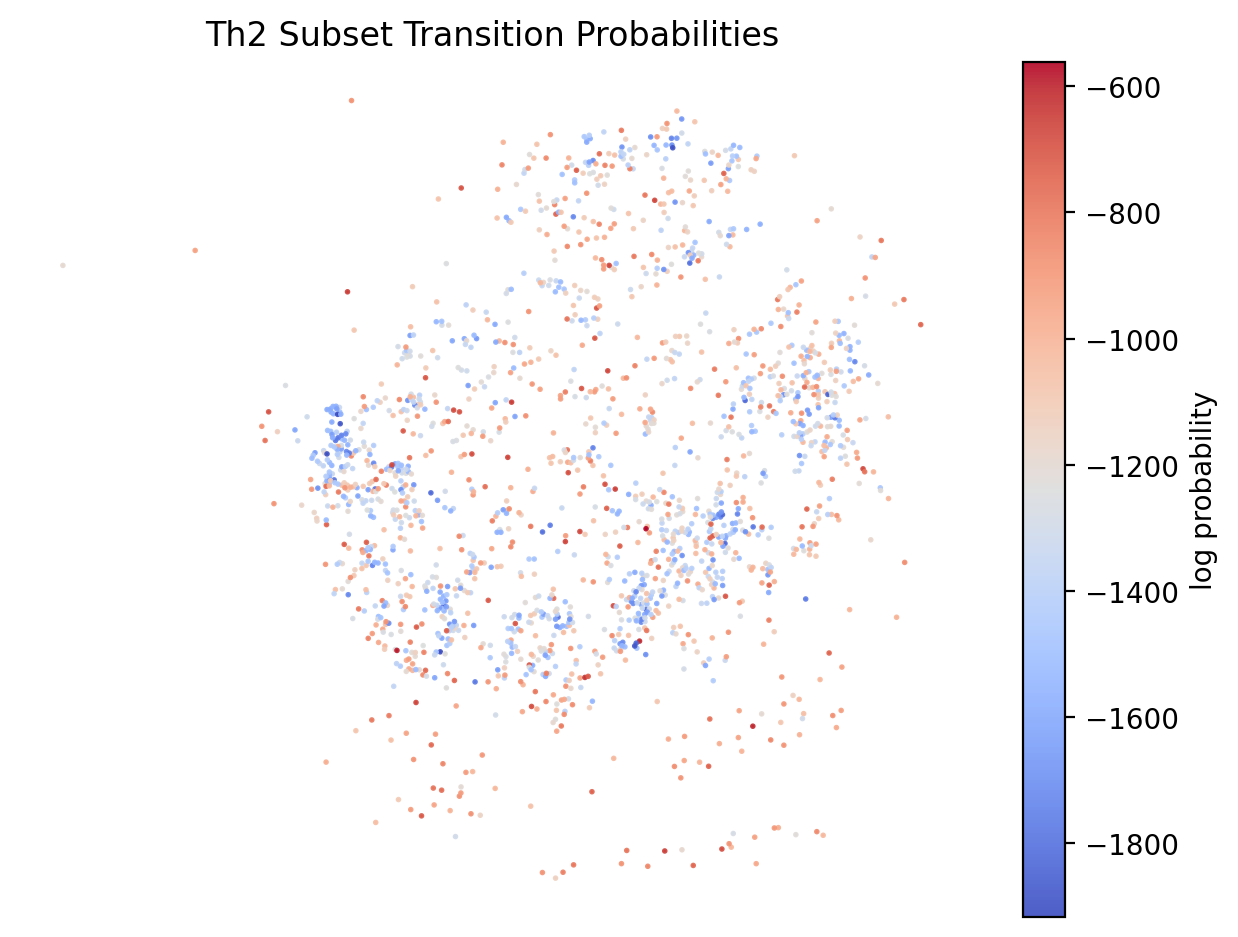

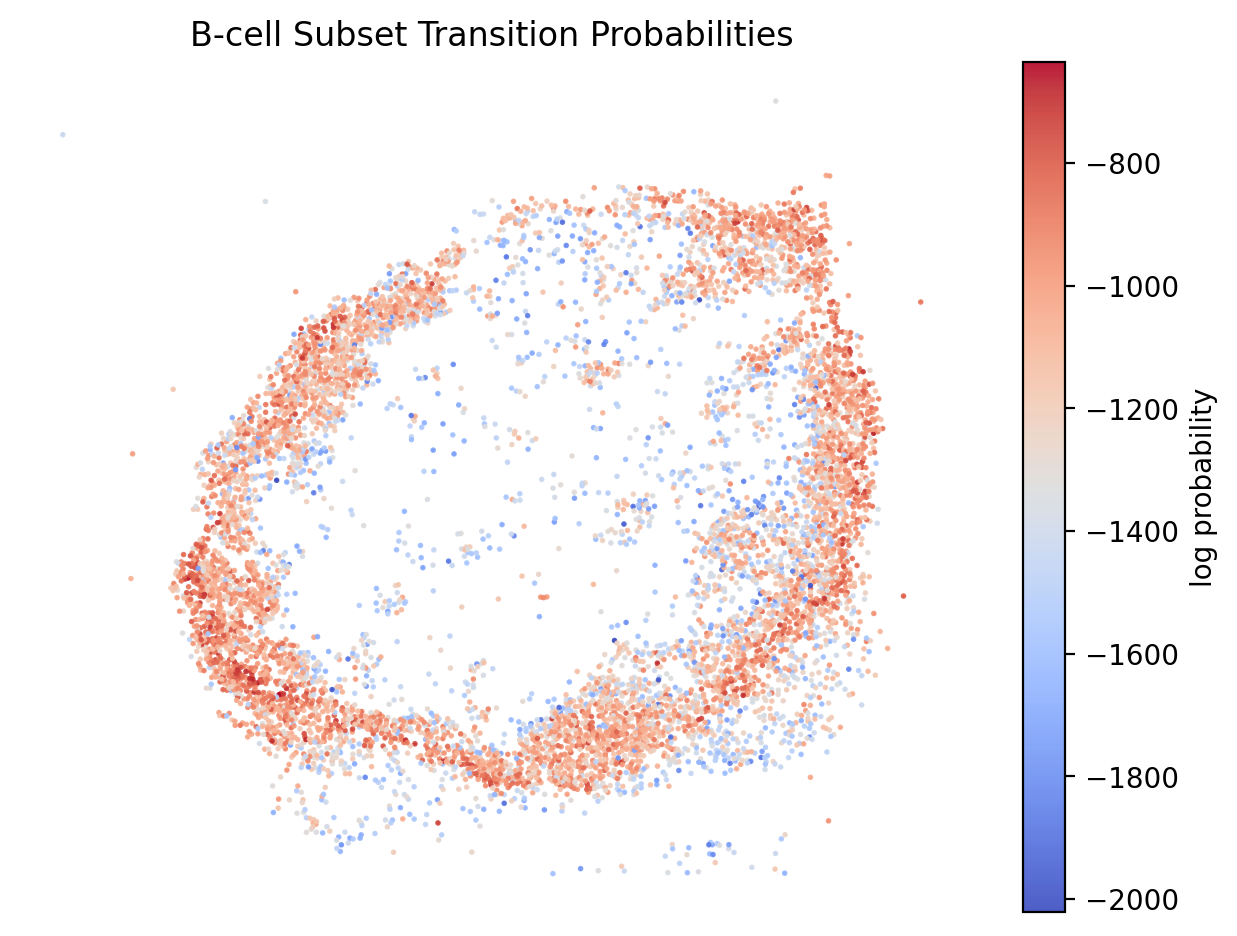

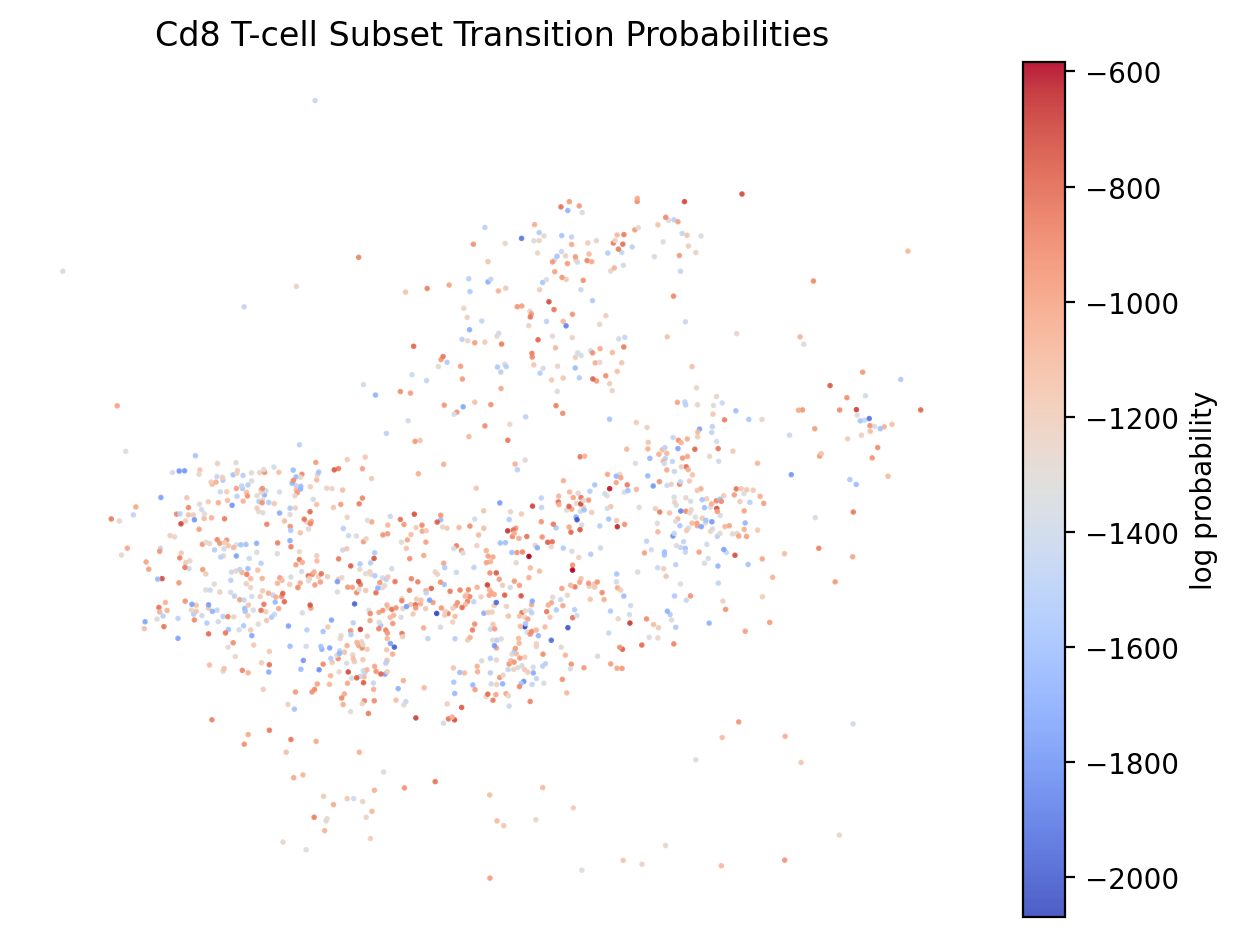

<Figure size 640x480 with 0 Axes>

In [14]:
from spaceoracle.plotting.transitions import *

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Th2', annot='rctd_celltypes', n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='B-cell', annot='rctd_celltypes', n_jobs=1)

view_probabilities(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['spatial'], cluster='Cd8 T-cell', annot='rctd_celltypes', n_jobs=1)

In [ ]:
from spaceoracle.plotting.transitions import *
from spaceoracle.plotting.randomize import *

estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
    annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)

randomize_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_draw_graph_fr'], 
    annot='rctd_cluster', grid_scale=2, vector_scale=0.5, n_jobs=4)

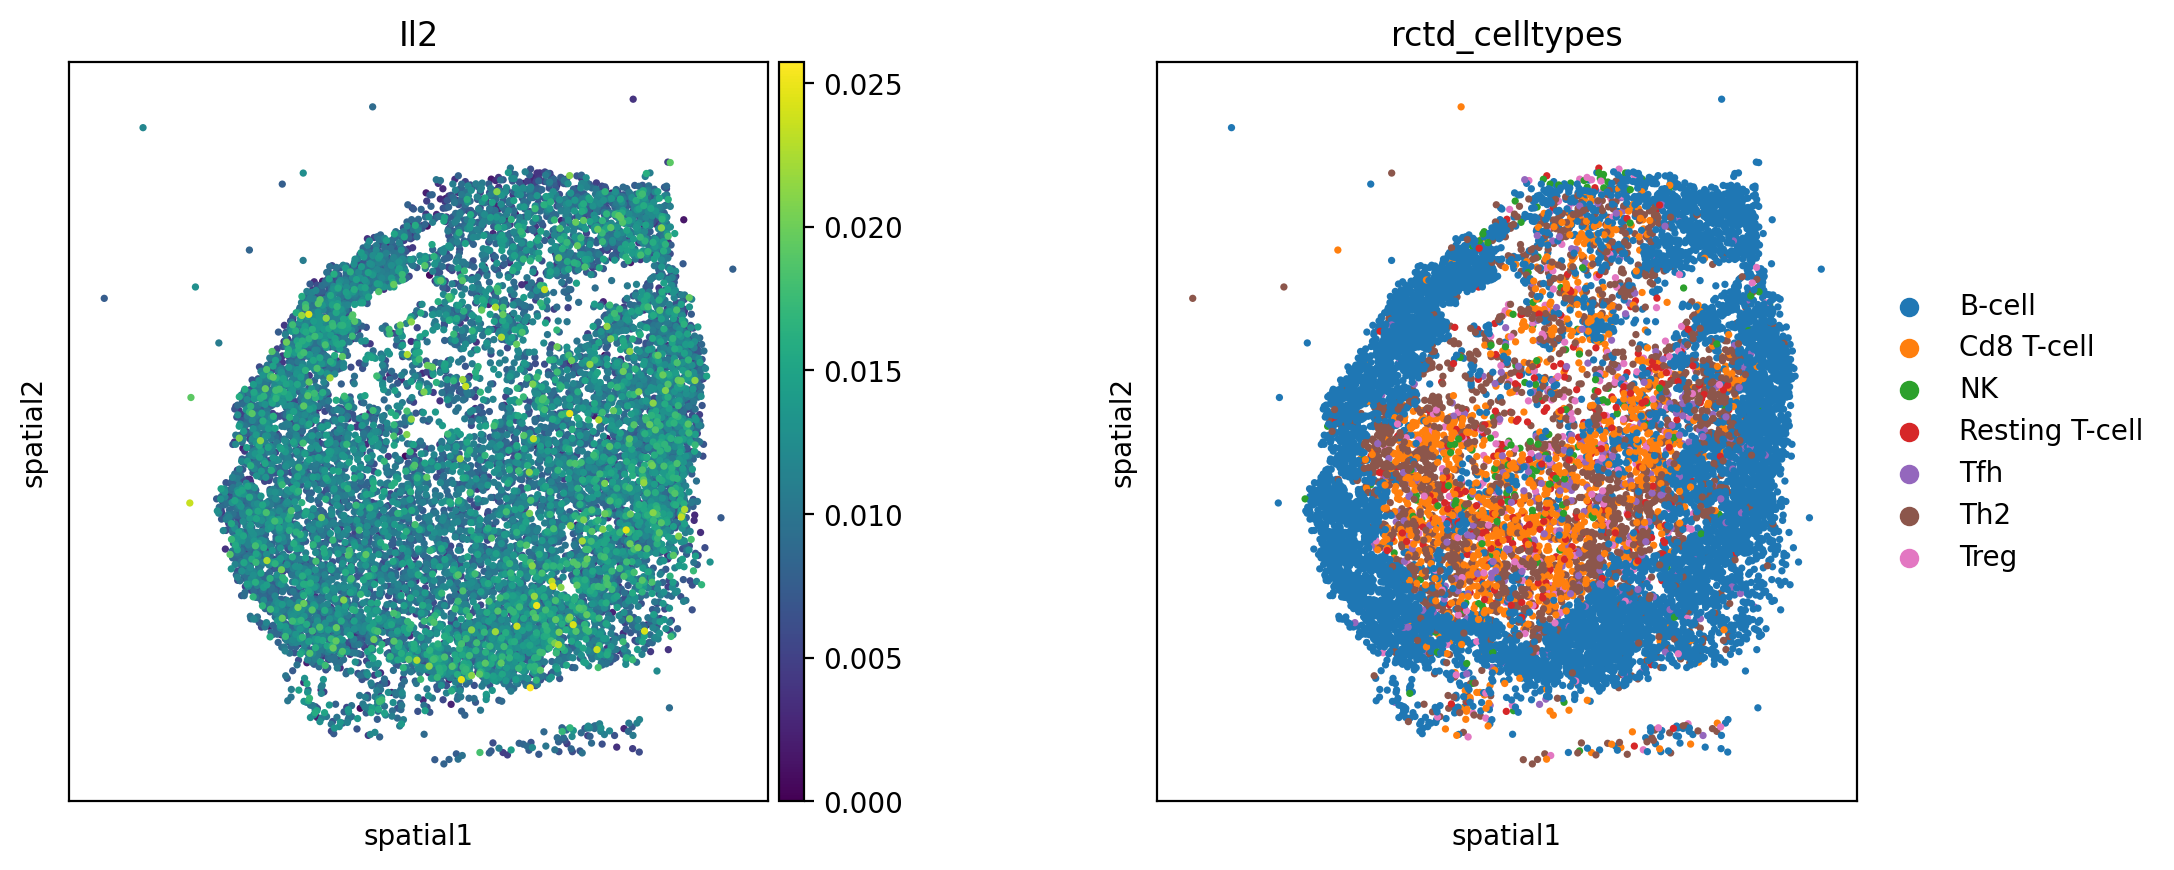

In [15]:
compare_gex(so.adata, annot='rctd_celltypes', goi=goi, embedding='spatial')

In [ ]:
# Using spatial embedding

from spaceoracle.plotting.transitions import *
from spaceoracle.plotting.randomize import *

estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_cluster', normalize=True, grid_scale=0.01, vector_scale=100, n_jobs=4)

randomize_transitions_2D(
    so.adata, so.adata.layers['delta_X'], so.adata.obsm['X_spatial'], 
    annot='rctd_cluster', normalize=True, grid_scale=0.01, vector_scale=100, n_jobs=4)

In [16]:
celltypes = ['B-cell', 'Cd8 T-cell']

cell_idxs = np.where(adata.obs['rctd_celltypes'].isin(celltypes))[0]
adata_ct = adata[adata.obs_names[cell_idxs]]
delta_X_ct = so.adata.layers['delta_X'][cell_idxs, :]

# view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=True)
embedding_ct = view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=False)

In [ ]:
estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot='rctd_celltypes', 
    normalize=True, grid_scale=0.01, vector_scale=1, n_jobs=1)

In [ ]:
celltypes = ['Th2', 'Cd8 T-cell']

cell_idxs = np.where(adata.obs['rctd_celltypes'].isin(celltypes))[0]

adata_ct = adata[adata.obs_names[cell_idxs]]
delta_X_ct = so.adata.layers['delta_X'][cell_idxs, :]

# view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=True)
embedding_ct = view_spatial3D(adata_ct, annot='rctd_celltypes', flat=True, show=False)

estimate_transitions_3D(
    adata_ct, delta_X_ct, embedding_ct, annot='rctd_celltypes', 
    normalize=True, grid_scale=0.01, vector_scale=1, n_jobs=1)

In [ ]:
from spaceoracle.plotting.similarity import *

plot_similarity_chains(
    so.adata, annot='rctd_cluster', n=5, ax=None, cluster=0, figsize=(6, 6))